# The Correlated Dice

## Definition of the Process

The random outcome of throwing a dice is $X_t \in \Omega =\{1,2,3,4,5,6\}$. Here we want to introduce the correlated dice where the probability for the initial dice roll is $p(X_t)=\frac{1}{|\Omega|}$ (where $|\Omega|$ is the power of the sample space.)
Each subsequent dice roll, however, has a higher/lower conditional probability $\tilde p$ to reproduce the outcome of the previous dice roll:

\begin{equation} 
p(X_{t+1}=x_{t+1}|X_t=x_t)=\begin{cases}
                    \tilde{p} \text{ for } x_{t+1}=x_t \\ 
                    \frac{1-\tilde{p}}{|\Omega|-1} \text{ for } x_{t+1} \neq x_t
                    \end{cases}
\end{equation}


For $\tilde p = 1/|\Omega|$ we recover the case of a normal, uncorrelated dice.

Assuming $0<\tilde p<1 $ (i.e. excluding $\tilde p \in \{0,1\}$ each outcome in the sample space will still be obtained in the long run. (For  $\tilde p \in \{1\}$ the outcome of the first dice roll $X_0=x_0$ dictates the outcomes of the following dice rolls to be equal to $X_t=x_0 \forall t$.)
For $0<\tilde p<1 $ and long times $t$, the mean value $E[X_t]$ is due to symmetry in the problem still the mean value of the uncorrelated dice.

The correlation $E[(X_{t+\tau}-\mu_{t+\tau})(X_{t}-\mu_{t})]$ can be computed in this case. The normalized autocorrelation function is $\frac{E[(X_{t+\tau}-\mu_{t+\tau})(X_{t}-\mu_{t})]}{E[(X_{t}-\mu_{t})(X_{t}-\mu_{t})]}$.

$E[(X_{t+\tau}-\mu_{t+\tau})(X_{t}-\mu_{t})] = \sum_{x_{t+\tau}} \sum_{x_t} (x_{t+\tau}-\mu_{t+\tau})(x_{t}-\mu_{t}) p(x_{t+\tau}, x_{t})$

The probability $p(x_{t+\tau}, x_{t})$ can be computed over all paths the experiment can take: $p(x_{t+2}, x_{t})=\int dx_{t+1} p(x_{t+2}, x_{t+1}, x_{t})$ and vice versa for more times:
\begin{equation}
p(x_{t+\tau}, x_{t})=\prod_i \int dx_{t+i} p(x_{t+\tau}, x_{t+i}...,x_{t+1}, x_{t})=p(x_t)\prod_{i=0}^{\tau-1} \int dx_{t+i}p(x_{t+i+1}|x_{t+i}).
\end{equation}
Therefore, each transition can be described by the transition probabilities/conditional probabilities above:
$p(x_{t+1}, x_t)= p(x_t) p(x_{t+1}| x_t)$.

For a delay of 2 steps we have for example $p(x_{t+2}, x_t)= \int dx_{t+1} p(x_t) p(x_{t+1}| x_t) p(x_{t+2}| x_{t+1})$

Below you find a numerical implementation of this process:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

%matplotlib notebook


sample_size = 4000
probability_of_same_result_as_before = 1.0 / 6.0 * 5

xk = range(1, 7)
pk = 1.0 / len(xk) * np.ones_like(xk)
initial_dice_roll = stats.rv_discrete(name="initial_dice_roll", values=(xk, pk))

pmf_previous_dice_roll = {}
for i in range(1, 7):
    # pmf_for_subsequent_dice_roll
    xk = range(1, 7)
    pk = (1.0 - probability_of_same_result_as_before) / (len(xk) - 1) * np.ones_like(xk)
    pk[i - 1] = probability_of_same_result_as_before
    pmf_previous_dice_roll[i] = stats.rv_discrete(
        name="conditional_distribution_dice_roll_" + str(i), values=(xk, pk)
    )

    # fig, ax = plt.subplots(1, 1)
    # ax.plot(xk, initial_dice_roll.pmf(xk), 'ro', ms=12, mec='r')
    # ax.vlines(xk, 0, initial_dice_roll.pmf(xk), colors='r', lw=4)
    # ax.plot(xk, pmf_previous_dice_roll[6].pmf(xk), 'bo', ms=12, mec='b')
    # ax.vlines(xk, 0, pmf_previous_dice_roll[6].pmf(xk), colors='b', lw=4)

    # plt.show()

random_experiment_outcome = []
random_experiment_outcome.append(initial_dice_roll.rvs(size=1)[0])

for i in range(sample_size):
    previous_outcome = random_experiment_outcome[-1]
    random_experiment_outcome.append(
        pmf_previous_dice_roll[previous_outcome].rvs(size=1)[0]
    )

## Estimating the autocorrelation function via samples

The estimated autocorrelation function (ACF) of this process is:

<IPython.core.display.Javascript object>


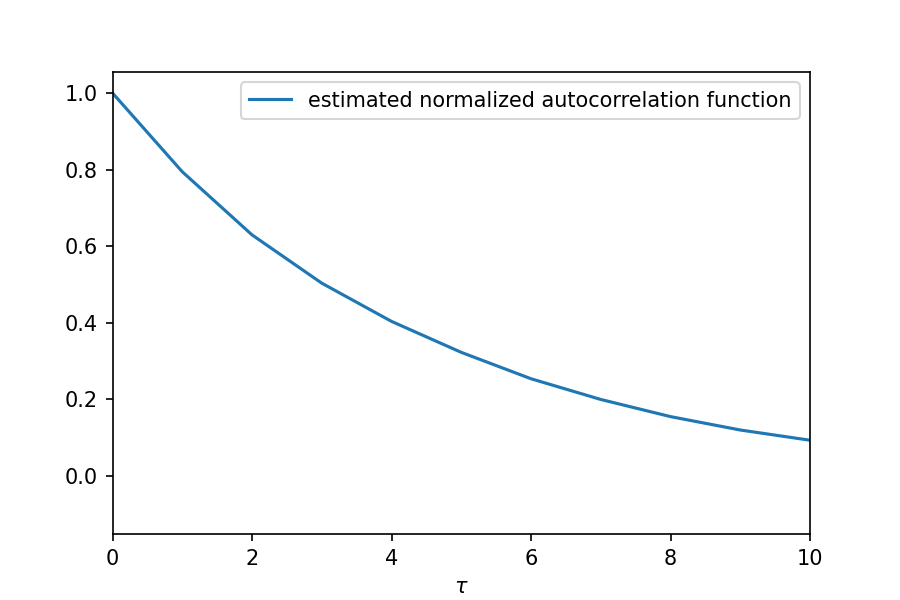

In [2]:
def autocorrelation(x, normalized=True):
    """
    Compute autocorrelation using FFT
    """
    # make a flat copy of the input array:
    x = np.array(x, dtype=np.float64, order="C", copy=True).ravel()
    n = x.shape[0]
    x -= x.mean()
    Frf = np.fft.fft(x)
    acf = np.fft.ifft(Frf * Frf.conj()).real[: n // 2] / n
    if normalized:
        acf /= acf[0]
    return acf


fig, ax = plt.subplots(figsize=(6, 4))
plt.xlim([0, 10])
plt.plot(
    autocorrelation(random_experiment_outcome),
    label="estimated normalized autocorrelation function",
)
plt.xlabel(r"$\tau$")
plt.legend()
plt.show()

## Intuition What does Correlation tell you?

The 2d histogram of pairs $(X_t-\mu_t, X_{t+\tau}-\mu_{t+\tau})$ is shown below. Execute the cell and change the silder to observe how the frequencies of similar outcomes (on the diagonals of the histogram) change with $\tau$:

<IPython.core.display.Javascript object>


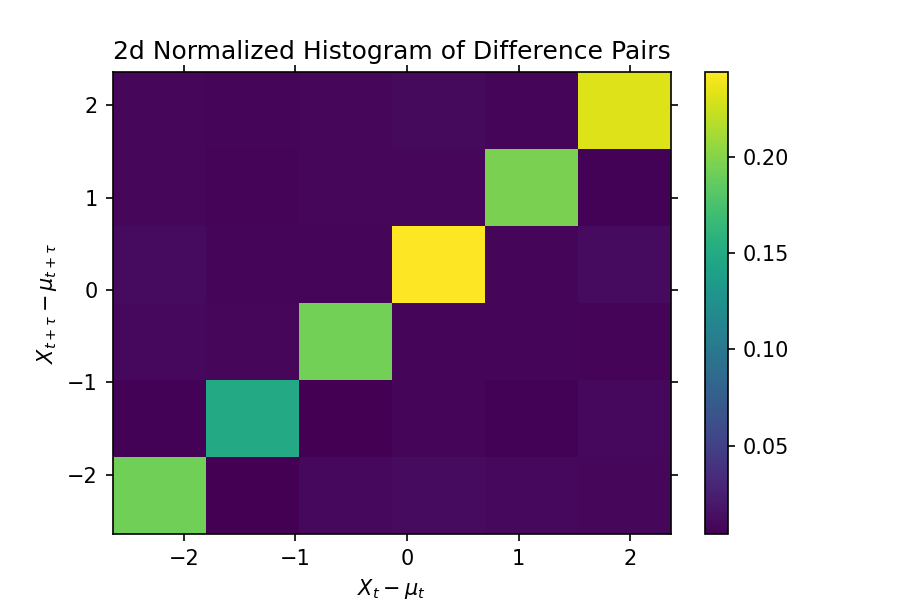

interactive(children=(IntSlider(value=1, description='tau', max=50, min=1), Output()), _dom_classes=('widget-i…

In [3]:
import ipywidgets as widgets

fig, ax = plt.subplots(figsize=(6, 4))


def my_data_centered(tau):
    xdata = random_experiment_outcome[0:-tau]
    xdata -= np.mean(xdata)

    ydata = np.roll(random_experiment_outcome, -tau)[0:-tau]
    ydata = ydata.astype("float32")
    ydata -= np.mean(ydata)

    return xdata, ydata


xdata, ydata = my_data_centered(tau=1)
cax = ax.hist2d(xdata, ydata, bins=len(xk), density=True)
cbar = fig.colorbar(cax[3])
_, colorbar_axes = plt.gcf().get_axes()


@widgets.interact(tau=(1, 50, 1))
def update(tau=1.0):
    ax.cla()

    xdata, ydata = my_data_centered(tau)

    ax.set_xlabel(r"$X_t-\mu_t$")
    ax.set_ylabel(r"$X_{t+\tau}-\mu_{t+\tau}$")
    ax.set_title("2d Normalized Histogram of Difference Pairs")
    cax_new = ax.hist2d(xdata, ydata, bins=len(xk), density=True)

    cbar = plt.colorbar(cax_new[3], cax=colorbar_axes)
    fig.canvas.draw_idle()

If $X_t-\mu_t$ and $X_{t+\tau}-\mu_{t+\tau}$ have the same sign this results in the product $(X_t-\mu_t)(X_{t+\tau}-\mu_{t+\tau})$ being positive. If this product tends to be more often positive than negative, then $E[(X_t-\mu_t)(X_{t+\tau}-\mu_{t+\tau})]=\sum_{x_t}\sum_{x_{t+\tau}} (x_t-\mu_t)(x_{t+\tau}-\mu_{t+\tau}) p(X_t=x_t, X_{t+\tau}=x_{t+\tau})>0$

Note that the normalized autocorrelation at time $\tau$ equals the slope of the linear fit through the data points {$(X_t, X_{t+\tau})$}:

### Relation to Linear Regression

It can be shown that fitting a linear regression model $Y_i = \beta_0 +\beta_1 X_i + \epsilon_i$ with parameters $\beta_{1,2}$ and noise $\epsilon_i \sim \mathcal{N}(\mu=0,\sigma^2=VAR(Y))$ we obtain the following relation:
$\hat{\beta}_1 = Cov(X,Y)/\sigma_X^2$ and $\hat{\beta}_0=\mu_y-\hat{\beta}_1\mu_x$ (see https://www.nasa.gov/sites/default/files/atoms/files/04_correlation_2016_cost_symposium_fkuo_tagged.pdf ).

For a time series, let us for example consider $X=X_t$ and $Y=X_{t+2}$ (i.e. $\tau=2$ !).
Then we have:$\hat{\beta}_1 = COV(X_t,X_{t+\tau})/\sigma_{X_t}^2=\frac{COV(X_t,X_{t+\tau})}{\sigma_{X_{t+\tau}}\sigma_{X_t}} \frac{\sigma_{X_{t+\tau}}}{\sigma_{X_t}}=AFC(\tau=2)\sigma_{X_{t+\tau}}/\sigma_{X_t}=AFC(\tau=2)$ (where the normalized ACF is introduced using its definition and the last simplification is true due to symmetry in time).

<IPython.core.display.Javascript object>


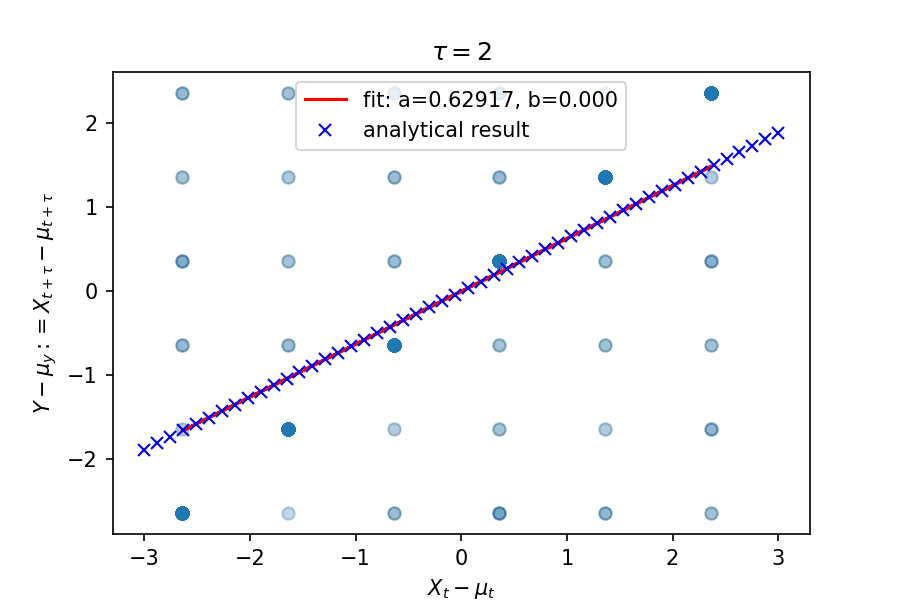

A data point with higher intensity occurs more often in the data.\
     Note how well the linear fit through the data matches the analytic result: \
      Slope of linear fit $slope = 0.629169$, \
       analytic result $\hat{\beta}_1$ = 0.629169 \
        as well as the normalized ACF($\tau=2$) = 0.629523

In [4]:
from IPython.display import Markdown as md
from scipy.optimize import curve_fit

tau = 2

# get shifted and centered data
xdata, ydata = my_data_centered(tau)

# compute fit


def linear_fit(x, a, b):
    return a * x + b


popt, pcov = curve_fit(linear_fit, xdata, ydata)

# compute analytical prediction
var_x = np.var(xdata, ddof=1)
cov_xy = np.cov(m=xdata, y=ydata)[0, 1]
hat_beta_1 = cov_xy / var_x
hat_beta_0 = np.mean(ydata) - hat_beta_1 * np.mean(xdata)

# plot
fig, ax = plt.subplots(figsize=(6, 4))
x_new = np.linspace(-3, 3)
plt.clf()
plt.scatter(xdata, ydata, alpha=0.01)
plt.plot(
    xdata, linear_fit(xdata, *popt), "r-", label="fit: a=%5.5f, b=%5.3f" % tuple(popt)
)
plt.plot(x_new, hat_beta_0 + hat_beta_1 * x_new, "bx", label="analytical result")
plt.xlabel(r"$X_t-\mu_t$")
plt.ylabel(r"$Y-\mu_y:=X_{t+\tau}-\mu_{t+\tau}$")
plt.title(r"$\tau = 2$")
plt.legend()


md(
    r"A data point with higher intensity occurs more often in the data.\
     Note how well the linear fit through the data matches the analytic result: \
      Slope of linear fit $slope = %f$, \
       analytic result $\hat{\beta}_1$ = %f \
        as well as the normalized ACF($\tau=2$) = %f"
    % (
        popt[0],
        hat_beta_1,
        autocorrelation(random_experiment_outcome, normalized=True)[2],
    )
)

A posteriori, we check that the assumption $\epsilon_i \sim \mathcal{N}(\mu=0,\sigma^2=VAR(Y))$ is not totally off for the correlated dice process:

<IPython.core.display.Javascript object>


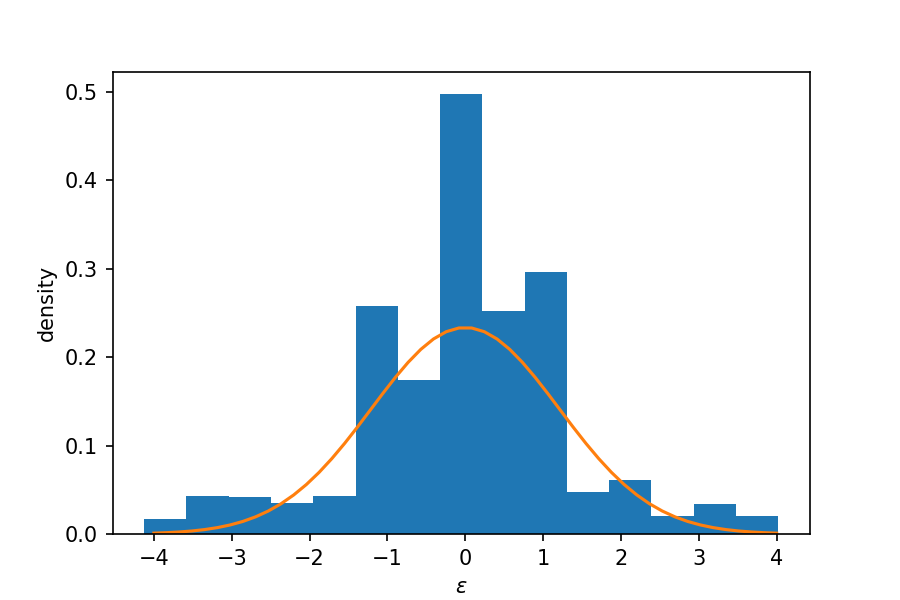

unique epsilons [-4.12452787 -3.49535856 -3.12452799 -2.86618926 -2.49535868 -2.23701996
 -2.12452793 -1.86618938 -1.60785066 -1.49535862 -1.23702008 -1.12452793
 -0.97868136 -0.86618932 -0.60785078 -0.49535862 -0.23702002 -0.12452799
  0.02131852  0.13381068  0.39214928  0.50464132  0.76297998  0.87547213
  1.02131858  1.13381062  1.39214928  1.50464144  1.76297992  2.02131858
  2.13381074  2.39214922  2.76298004  3.02131852  3.39214934  4.02131864]


In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.clf()
epsilon = ydata - hat_beta_0 - hat_beta_1 * xdata
plt.hist(epsilon, density=True, bins=15)
plt.ylabel("density")
plt.xlabel(r"$\epsilon$")
epsilons_val = np.linspace(-4, 4)
var_y = np.var(ydata, ddof=1)
plt.plot(
    epsilons_val,
    1 / np.sqrt(2 * np.pi * var_y) * np.exp(-(epsilons_val ** 2) / var_y),
    label="Gaussian",
)
plt.show()
# However note that there is a finite number of computed epsilon_values since xdata and ydata are discrete:
print("unique epsilons", np.unique(epsilon))

# Numerical Computation of the Expected Autocorrelation using Transition Probabilities

For the correlated dice process we are computing the correlation coefficient presented in the introduction for $\tau=1$ numerically. For a discrete process the integration there is a summation. For $\tau =1$ we have $p(x_{t+1}, x_t)= p(x_t) p(x_{t+1}| x_t)$ and $\mu_t = \mu_{t+\tau}=3.5$.

$E[(X_{t+1}-\mu)(X_{t}-\mu)] = \sum_{x_{t+1}} \sum_{x_t} (x_{t+1}-\mu)(x_{t}-\mu) p(x_t) p(x_{t+1}| x_t)$

i.e.: $E[(X_{1}-\mu)(X_{0}-\mu)] = \sum_{x_{1} \in \Omega} \sum_{x_0 \in \Omega} (x_{1}-\mu)(x_{0}-\mu) p(x_0) p(x_{1}| x_0)$

In [6]:
autocorrelation_at_tau_1 = 0
probability_initial_dice_roll = 1.0 / 6.0


def conditional_probability(x1, x0):
    if x1 == x0:
        return probability_of_same_result_as_before
    else:
        return (1.0 - probability_of_same_result_as_before) / (6 - 1)


mu = 3.5
for outcome_i in range(1, 7):
    for outcome_j in range(1, 7):
        autocorrelation_at_tau_1 += (
            (outcome_i - mu)
            * (outcome_j - mu)
            * probability_initial_dice_roll
            * conditional_probability(outcome_j, outcome_i)
        )
print("analytical result:", autocorrelation_at_tau_1)
print(
    "numerical estimate (gets more accurate with increasing sample size): ",
    autocorrelation(random_experiment_outcome, normalized=False)[1],
)

analytical result: 2.333333333333333
numerical estimate (gets more accurate with increasing sample size):  2.3172829636879695


The autocorrelation function of a Markov-Chain of length 1 can be computed by noting that the [transition matrix](https://en.wikipedia.org/wiki/Stochastic_matrix) $P_{t+1|t} (\forall t)$ propagates the probabilities. Given the initial probability of states is the vector $\vec{P}_0$ (and each entry in the vector is the probability to find the given state), the probabilities to find the system at time d in the states is $\vec{P}_d=(P_{t+1|t})^d \vec{P}_0$.

In [7]:
transition_matrix = np.zeros((6, 6))
for i in range(0, 6):
    for j in range(0, 6):
        transition_matrix[i, j] = conditional_probability(i, j)

not_normalized_autocorrelation = []
tau_max = 30  # maximum tau for which we compute the errorbar
for tau in range(0, tau_max):
    autocorrelation_at_tau = 0
    probability_state_tau = np.linalg.matrix_power(transition_matrix, tau)
    for outcome_i_at_tau in range(1, 7):
        for outcome_j_at_0 in range(1, 7):
            initial_probabilities = np.zeros(6)
            initial_probabilities[outcome_j_at_0 - 1] = probability_initial_dice_roll
            autocorrelation_at_tau += (
                (outcome_i_at_tau - mu)
                * (outcome_j_at_0 - mu)
                * np.dot(probability_state_tau, initial_probabilities)[
                    outcome_i_at_tau - 1
                ]
            )
    not_normalized_autocorrelation.append(autocorrelation_at_tau)

# Estimation of Confidence Intervals for the empirical ACF

## Simple Standard Error

<IPython.core.display.Javascript object>


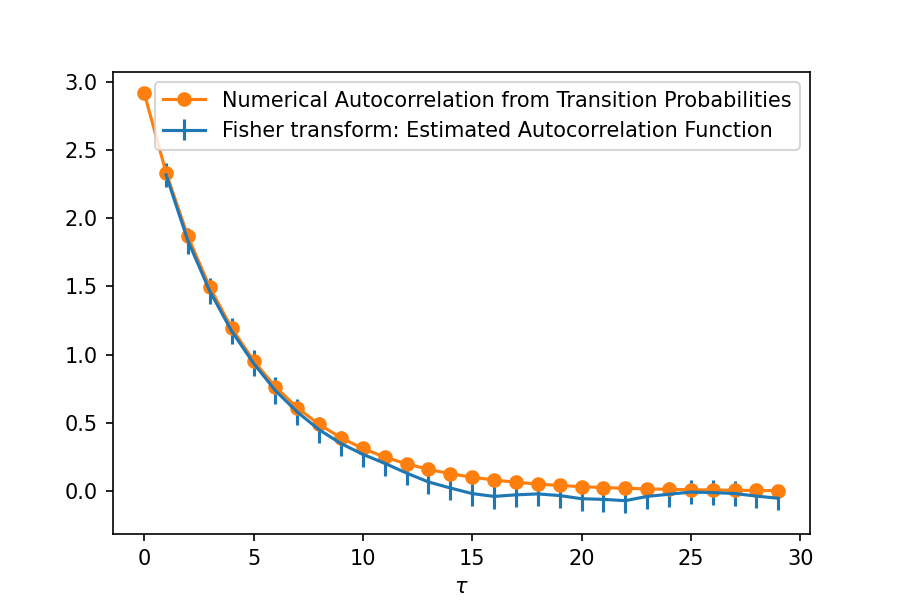

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))


def compute_not_normalized_autocorrelation_slow(random_experiment_outcome, lag):
    # return the autocorrelation at tau=lag and the 99% confidence interval
    x_data = random_experiment_outcome[:-lag] - np.mean(
        random_experiment_outcome[:-lag]
    )
    y_data = random_experiment_outcome[lag:] - np.mean(random_experiment_outcome[lag:])
    N = len(random_experiment_outcome[lag:])
    z_score = 1.96  # 95% confidence interval boundary
    standard_error = np.std(x_data * y_data, ddof=1, axis=0) / np.sqrt(N)
    return np.mean(x_data * y_data, axis=0), z_score * standard_error


not_normalized_autocorrelation_estimated = np.array(
    [
        (
            tau,
            *compute_not_normalized_autocorrelation_slow(
                random_experiment_outcome, tau
            ),
        )
        for tau in range(1, 30)
    ]
)

plt.errorbar(
    not_normalized_autocorrelation_estimated[:, 0],
    not_normalized_autocorrelation_estimated[:, 1],
    not_normalized_autocorrelation_estimated[:, 2],
    label="Fisher transform: Estimated Autocorrelation Function",
)
plt.plot(
    np.array(not_normalized_autocorrelation),
    label="Numerical Autocorrelation from Transition Probabilities",
    marker="o",
    linestyle="-",
)
plt.xlabel(r"$\tau$")
plt.legend()
plt.show()

Lines are just plotted as a guide to the eye (in the correlated dice process there is only discrete values of $\tau$ possible).

## Fisher transformation

The [Fisher transformation](https://en.wikipedia.org/wiki/Fisher_transformation) can be applied to stabilize the the confidence interval computation because it removes skewness. It is surely valid to use if the $(X,Y) \sim \mathcal{N}$ are already normally distributed, because then there is no skewness to be remove by the transformation. With this, we can provide confidence intervals for the estimated (normalized) correlation function $\rho$.

In [9]:
rho_hat = autocorrelation(random_experiment_outcome, True)[:tau_max]
rho_hat_without_tau_zero = rho_hat[1:]
# apply Fisher transformation
z = np.arctanh(rho_hat_without_tau_zero)
taus = np.arange(1, tau_max)
N = sample_size - taus
std_z = 1 / np.sqrt(N - 3)
z_score = 1.96  # 95% confidence interval boundary
z_low = z - z_score * std_z
z_high = z + z_score * std_z
# transform back
rho_hat_low = np.tanh(z_low)
rho_hat_high = np.tanh(z_high)

# take care of the value for tau=0
rho_hat_low_fisher = np.insert(rho_hat_low, 0, 1)
rho_hat_high_fisher = np.insert(rho_hat_high, 0, 1)

error_low_fisher = (
    autocorrelation(random_experiment_outcome, True)[:tau_max] - rho_hat_low_fisher
)
error_high_fisher = (
    rho_hat_high_fisher - autocorrelation(random_experiment_outcome, True)[:tau_max]
)

Now we can plot the estimated normalized AFC including the errorbars and the numerical AFC everything:

<IPython.core.display.Javascript object>


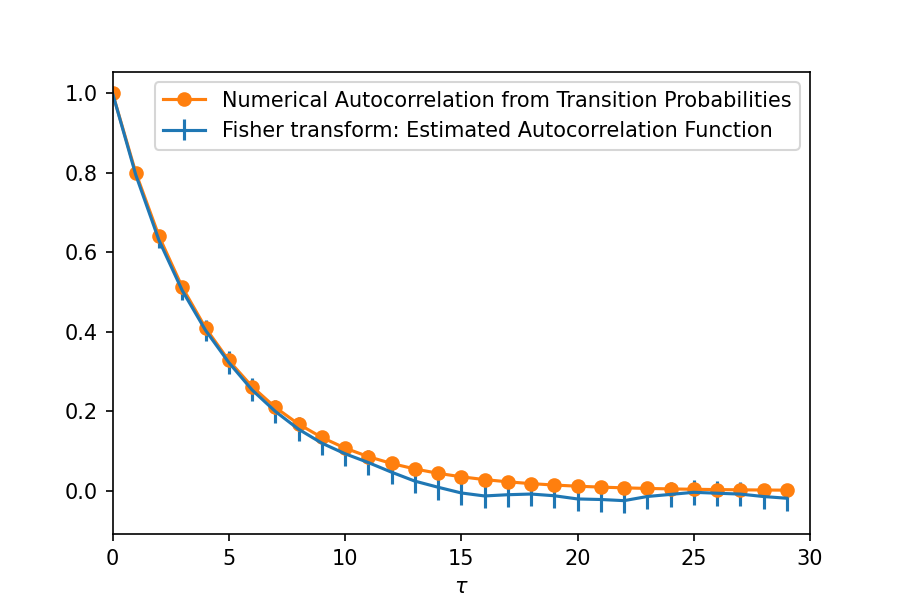

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.xlim([0, tau_max])
plt.errorbar(
    np.arange(0, tau_max),
    rho_hat,
    yerr=[error_low_fisher, error_high_fisher],
    label="Fisher transform: Estimated Autocorrelation Function",
)
plt.plot(
    np.array(not_normalized_autocorrelation / not_normalized_autocorrelation[0]),
    label="Numerical Autocorrelation from Transition Probabilities",
    marker="o",
    linestyle="-",
)
plt.xlabel(r"$\tau$")
plt.legend()
plt.show()

Unfortunately, the reported confidence intervals are too optimistic which is not too astonishing because the discrete distribution of dice roll outcomes violates assumptions made when deriving the confidence intervals with the Fisher z-Transformation.
Clearly the Fisher-z-transform did not help make the confidence intervals better in this example (since they pretty much agree with the standard approach above.

## Corellograms

Yet another way to illustrate the confidence intervals of the estimated autocorrelation function is the [correlogram](https://en.wikipedia.org/wiki/Correlogram), where the confidence intervals are shown as a blue tube directly around along the x-axis. 
If the estimated autocorrelation lies outside the tube then the null hypothesis H0 (there s no autocorrelation) is rejected, otherwise H0 is accepted.
In the statsmodels module the confidence intervals are computed via Bartletts formula (yet another approach).

<IPython.core.display.Javascript object>


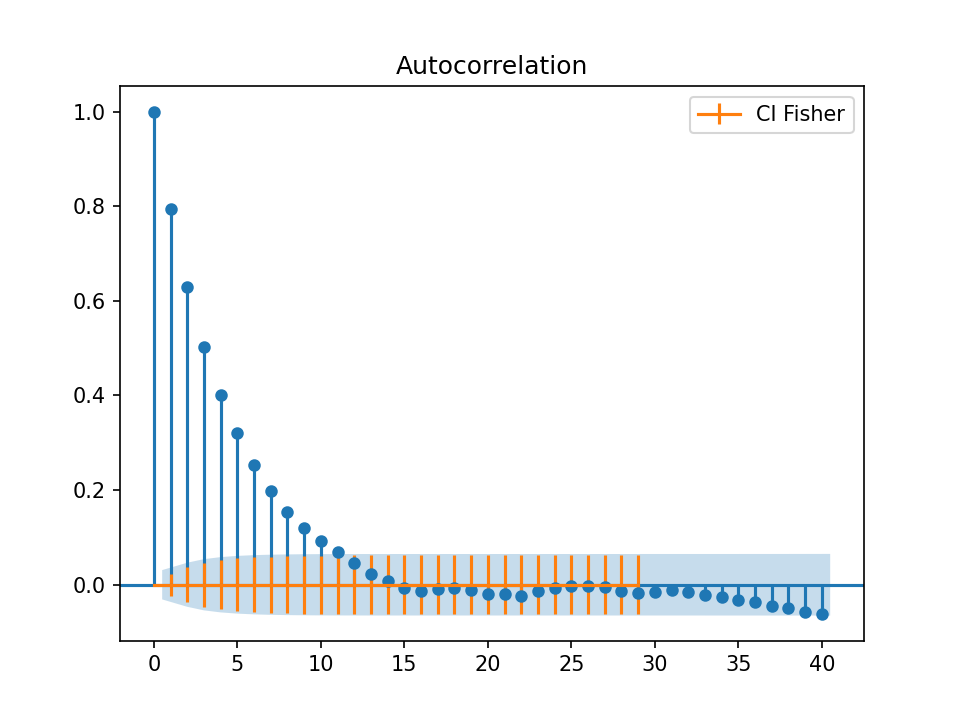

In [11]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(random_experiment_outcome, lags=40)
plt.errorbar(
    np.arange(0, tau_max),
    np.zeros(tau_max),
    error_low_fisher + error_high_fisher,
    label="CI Fisher",
)
plt.legend()
plt.show()

# Consequences of Correlations for Computing the Uncertainty of Mean Values

The sample mean of the time series is $\overline{X} = \frac{1}{N}\sum_{i=1}^N X_i$, the variance of the sample mean is $Var(\overline{X})$. For uncorrelated data the variance of the estimated mean is the squared standard error and is simply computed via the sample variance:
$Var(\overline{X})= Var(X)/N$.

For correlated data the standard error of the estimated mean $\sigma(\overline{X})$ is not simply $\sigma(X)/\sqrt{N}$ but needs to be corrected with a term containing the autocorrelation function (see [Markov Chain Cental limit theorem](https://en.wikipedia.org/wiki/Markov_chain_central_limit_theorem), [The moving block bootstrap to assess the accuracy of statistical estimates in Ising model simulations](https://www.sciencedirect.com/science/article/abs/pii/0010465595001147?via%3Dihub)):
$\sigma(\overline{X})^2=\frac{Var(X)}{N}(1+\frac{2}{N}\sum_{i=1}^{N-1}(N-k)\rho(k))$

In [12]:
def calc_error_return_Neff(data):
    """
    Error estimation for time series of simulation observables and take into
    account that these series are to some kind degree correlated (which
    enhances the estimated statistical error).
    """
    # calculate the normalized autocorrelation function of data
    acf = autocorrelation(data)
    # calculate the integrated correlation time tau_int
    # (Janke, Wolfhard. "Statistical analysis of simulations: Data correlations
    # and error estimation." Quantum Simulations of Complex Many-Body Systems:
    # From Theory to Algorithms 10 (2002): 423-445.)
    tau_int = 0.5
    for i in range(len(acf)):
        tau_int += acf[i] * (1 - i / len(data))
        if i >= 10 * tau_int:
            break  # the integration of the estimated ACF needs to be cut off because it becomes unreliable
    # mean value of the time series
    data_mean = np.mean(data)
    # calculate the so called effective length of the time series N_eff
    Neff = np.nan
    if tau_int > 0.5:
        N_eff = len(data) / (2.0 * tau_int)
        # finally the error is sqrt(var(data)/N_eff)
        stat_err = np.std(data, ddof=1) / np.sqrt(N_eff)
    else:
        N_eff = len(data)
        stat_err = np.std(data, ddof=1) / np.sqrt(len(data))
    return data_mean, stat_err, N_eff


(
    estimated_mean,
    estimated_std_deviation_of_estimated_mean,
    N_eff,
) = calc_error_return_Neff(random_experiment_outcome)
print(
    "estimated_mean",
    estimated_mean,
    "correlation corrected estimated_std_deviation_of_estimated_mean",
    estimated_std_deviation_of_estimated_mean,
)

estimated_std_deviation_of_estimated_mean_uncorrected = np.std(
    random_experiment_outcome, ddof=1
) / np.sqrt(len(random_experiment_outcome))

print(
    "uncorrected standard error of the mean ",
    estimated_std_deviation_of_estimated_mean_uncorrected,
)

ratio_of_confidence_intervals = (
    estimated_std_deviation_of_estimated_mean
    / estimated_std_deviation_of_estimated_mean_uncorrected
)
print("Ratio of correct error to standard error ", ratio_of_confidence_intervals)

estimated_mean 3.6403399150212445 correlation corrected estimated_std_deviation_of_estimated_mean 0.0794201036995297
uncorrected standard error of the mean  0.027005244866407888
Ratio of correct error to standard error  2.9409140369736555


Note that the estimated mean and the true mean (3.5) deviate.
If correlations are **not** accounted for, then the estimate for the standard error is too small (by a factor of ~3).

Note that another possibility to estimate the error of the estimate of the mean value of a correlated time series is block bootstrap, see [The moving block bootstrap to assess the accuracy of statistical estimates in Ising model simulations](https://www.sciencedirect.com/science/article/abs/pii/0010465595001147?via%3Dihub).